Подключение библиотек и скриптов

In [454]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [455]:
 !pip install lightautoml

In [456]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from catboost import CatBoostRegressor

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [457]:
import warnings
warnings.filterwarnings('ignore')

In [458]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [459]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Пути к директориям и файлам

In [460]:
TRAIN_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'

# Загрузка данных

In [461]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorRooms,MedPriceByFloorYear
0,4567,44,1.0,36.847630,19.094182,5.0,5.0,9.0,1970,0.036122,...,0,0,0,104.0,1,1.0,2.0,171145.169069,155974.300833,186447.337908
1,5925,62,1.0,55.568133,42.568133,10.0,7.0,17.0,2017,0.072158,...,0,0,0,247.0,1,2.0,5.0,129107.218932,156067.264282,172932.855768
2,960,27,2.0,59.463678,47.463678,9.0,19.0,19.0,1977,0.211401,...,0,0,1,851.0,1,4.0,2.0,165683.084779,200552.798556,175503.767602
3,3848,23,3.0,49.646030,33.893825,6.0,2.0,2.0,1965,0.014073,...,0,0,0,565.0,1,0.0,2.0,166687.735824,244124.424428,179646.198587
4,746,74,1.0,53.837056,46.837056,4.0,8.0,17.0,1977,0.309479,...,0,0,1,114.0,1,2.0,2.0,165071.825722,159350.917190,192213.977261


In [462]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


Привидение типов

In [463]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [464]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

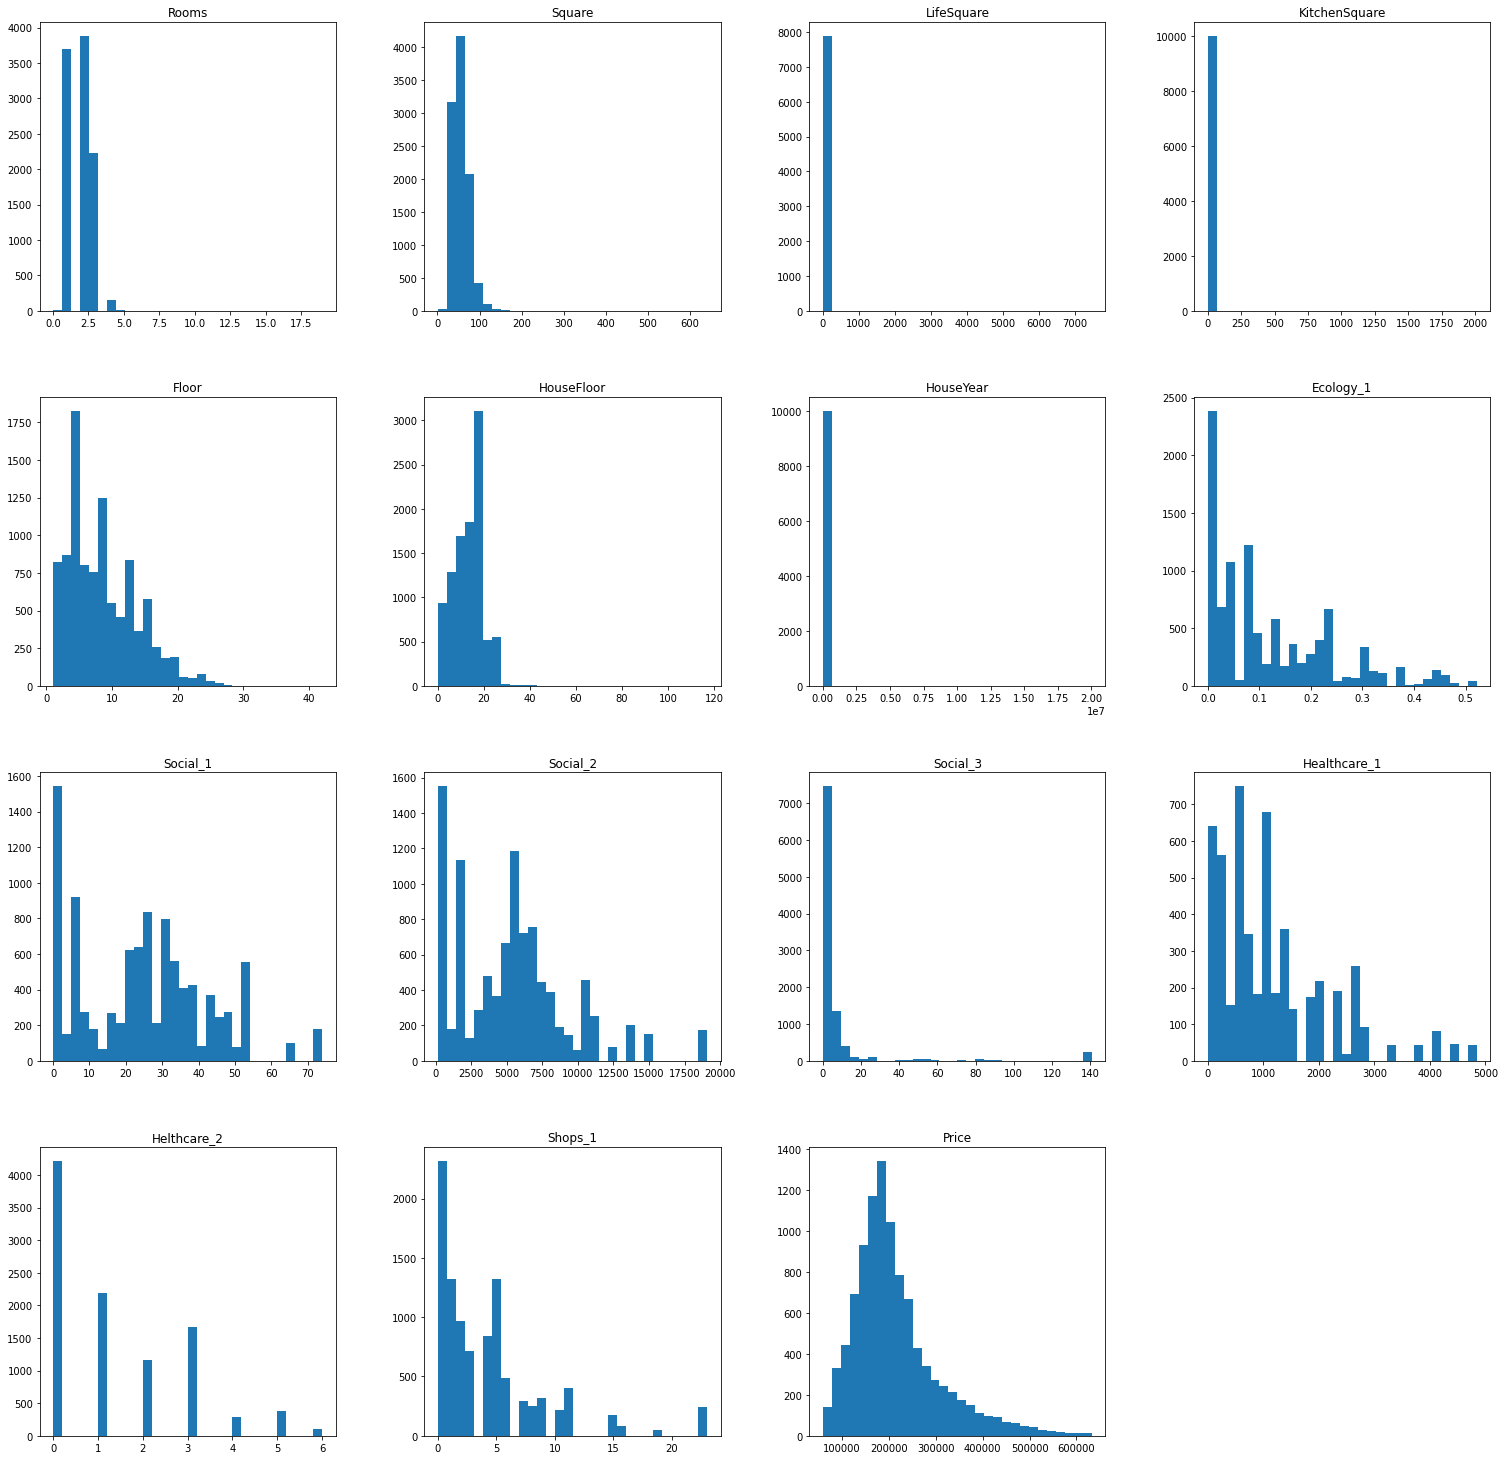

In [465]:
train_df.select_dtypes(include=['float64', 'int64', 'float16']).hist(figsize=(26,26), bins=30, grid=False);

# EDA

Переменные

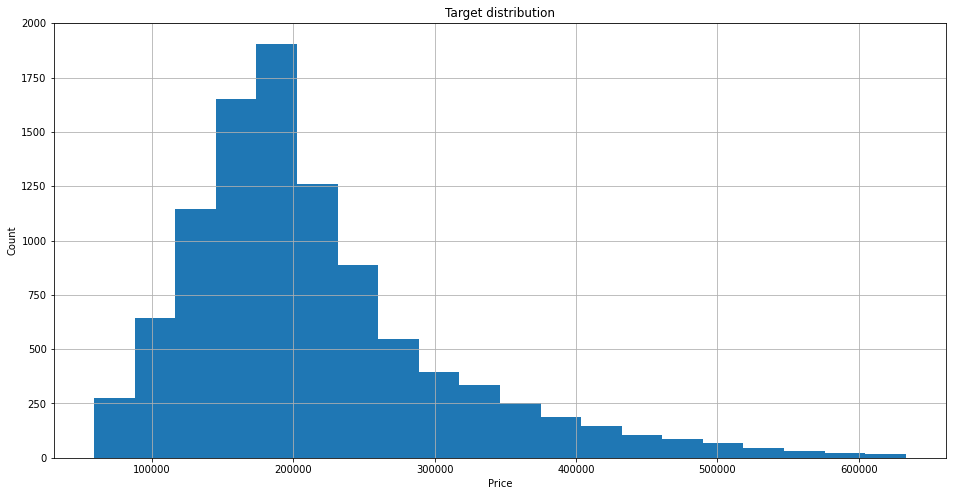

In [466]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=20)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [467]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [468]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [469]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

In [470]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [471]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [472]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

# Обработка выбросов

Rooms

In [473]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [474]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [475]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [476]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

KitchenSquare

In [477]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

In [478]:
train_df['KitchenSquare'].mean()

6.2733

In [479]:
train_df['KitchenSquare'].median()

6.0

Размер кухни меньше 4 метров вряд ли бывает, поэтому всем значениям менее 4 присвоим значение 4
Площадь кухни более 20 метров тоже скорее всего выбросы, поэтому присвоим им значение медианы 

In [480]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [481]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 4, 'KitchenSquare'] = 4

In [482]:
train_df['KitchenSquare'].value_counts()

4.0     3222
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
Name: KitchenSquare, dtype: int64

Square

Минимальная площадь дома 1 метр и жилая площадь 0.37метра явно выбросы. Посмотрим значения меньше 2.5 и больше 97.5 квантиля. Значениям больше 0.975 квантиля присвоим значение медианы, значениям меньше 0.025 квантиля - значение 0.025 квантиля

In [483]:
train_df['Square'].quantile(0.975), train_df['Square'].quantile(0.025)

(100.90624548226137, 32.10518291149681)

In [484]:
condition = (train_df['Square'].isna()) | (train_df['Square'] > train_df['Square'].quantile(.975))
        
train_df.loc[condition, 'Square'] = train_df['Square'].median()

train_df.loc[train_df['Square'] < 32, 'Square'] = 32

HouseFloor, Floor, 

Теперь посмотрим на столбцы с данными этажности дома, этажами расположения квартир

In [485]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [486]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [487]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [488]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [489]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [490]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

В значениях, где этажность квартиры выше этажности дома вероятнее всего при занесении данных были перепутаны столбцы и нужно здесь поменять местами значения

In [491]:
train_df.loc[floor_outliers, 'Floor'] = train_df['HouseFloor']
train_df.loc[floor_outliers, 'HouseFloor'] = train_df['Floor']

In [492]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

HooseYear

Год постройки дома. Он не может быть больше текущего года, то есть 2022, поэтому выбросами будут считаться все значения года больше 2022 

In [493]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [494]:
current_year = datetime.now().year
    
train_df['HouseYear_outlier'] = 0
train_df.loc[train_df['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
train_df.loc[train_df['HouseYear'] > current_year, 'HouseYear'] = current_year

# Обработка пропусков

In [495]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
HouseYear_outlier        0
dtype: int64

In [496]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head()

,Square,LifeSquare,KitchenSquare
0,52.513310,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,4.0
4,64.285067,38.562517,9.0


Так как в столбце LifeSquare отсутствует много значений, но есть значения общей площади и площади кухни, то тут можно просто от общей площади отнять значения площади кухни и отнять 3, как минимальную площадь санузла, которая здесь не учитывается, но присутствует в любой квартире. 

In [497]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

In [498]:
((train_df['LifeSquare'] + train_df['KitchenSquare'] + 3) > train_df['Square']).sum()

1357

Сумма жилой площади и кухни плюс минимальные 3 метра на санузел в 1357 наблюдениях превышают общую площадь квартиры. Для этих наблюдений общую площадь приравняем к сумме известных площадей

In [499]:
condition = ((train_df['LifeSquare'] + train_df['KitchenSquare'] + 3) > train_df['Square'])

train_df.loc[condition, 'Square'] = train_df['KitchenSquare'] + train_df['LifeSquare'] + 3

In [500]:
((train_df['LifeSquare'] + train_df['KitchenSquare'] + 3) > train_df['Square']).sum()

0

Healthcare_1

In [501]:
train_df['Healthcare_1'].describe()

count    5202.000000
mean     1142.904460
std      1021.517264
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

In [502]:
train_df_mean = round(train_df['Healthcare_1'].mean(), 2)
train_df_median = train_df['Healthcare_1'].median()
train_df_mode = train_df['Healthcare_1'].mode()
print(train_df_mean)
print(train_df_median)
print(train_df_mode)

1142.9
900.0
0    540.0
dtype: float64


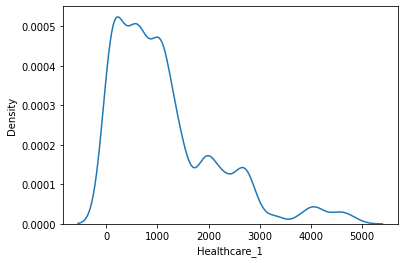

In [503]:
sns.kdeplot(train_df['Healthcare_1'])

In [504]:
train_df['Healthcare_1'].fillna(train_df_median, inplace=True)

In [505]:
train_df.isna().sum()

Id                    0
DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Healthcare_1          0
Helthcare_2           0
Shops_1               0
Shops_2               0
Price                 0
Rooms_outlier         0
HouseFloor_outlier    0
HouseYear_outlier     0
LifeSquare_nan        0
dtype: int64

# DataPreprocessing

In [506]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        self.square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        self.square_quantile = X['Square'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 4, 'KitchenSquare'] = 4
        
        # Square
        condition = (X['Square'].isna()) | (X['Square'] > self.square_quantile)
        X.loc[condition, 'Square'] = self.medians['Square']

        X.loc[X['Square'] < 32, 'Square'] = 32

        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X['HouseFloor']
        X.loc[floor_outliers, 'HouseFloor'] = X['Floor']
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        X['Healthcare_1'].fillna(self.medians, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        condition = ((X['LifeSquare'] + X['KitchenSquare'] + 3) > X['Square'])
        X.loc[condition, 'Square'] = X['KitchenSquare'] + X['LifeSquare'] + 3
        
        X.fillna(self.medians, inplace=True)
        
        return X

# Построение новых признаков

Dummies

In [507]:
binary_to_numbers = {'A': 0, 'B': 1}
train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

DistrictSize, IsDistrictLarge

In [508]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [509]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize
0,11809,27,3.0,52.513310,39.513310,10.0,4.0,10.0,2014,0.075424,...,900.0,0,0,1,305018.871089,0,0,0,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,1183.0,1,0,1,177734.553407,0,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,240.0,3,1,1,282078.720850,0,0,0,0,652
3,2352,1,1.0,40.409907,33.409907,4.0,10.0,22.0,1977,0.007122,...,900.0,0,1,1,168106.007630,0,0,0,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,900.0,0,6,1,343995.102962,0,0,0,0,89


In [510]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [511]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

MedPriceByDistrict

In [512]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [513]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,52.513310,39.513310,10.0,4.0,10.0,2014,0.075424,...,0,1,305018.871089,0,0,0,1,851,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,0,1,177734.553407,0,0,0,0,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,1,1,282078.720850,0,0,0,0,652,1,244005.272380
3,2352,1,1.0,40.409907,33.409907,4.0,10.0,22.0,1977,0.007122,...,1,1,168106.007630,0,0,0,1,652,1,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,6,1,343995.102962,0,0,0,0,89,0,201584.441255


MedPriceByFloorRooms

In [514]:
med_price_by_floor_rooms = train_df.groupby(['Floor', 'Rooms'], as_index=False).agg({'Price': 'median'})\
               .rename(columns={'Price':'MedPriceByFloorRooms'})

med_price_by_floor_rooms.head()     

,Floor,Rooms,MedPriceByFloorRooms
0,1.0,1.0,143327.711053
1,1.0,2.0,185818.846496
2,1.0,3.0,231556.854092
3,1.0,4.0,356332.296643
4,1.0,5.0,317674.574137


In [515]:
train_df = train_df.merge(med_price_by_floor_rooms, on=['Floor', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,MedPriceByFloorRooms
0,11809,27,3.0,52.513310,39.513310,10.0,4.0,10.0,2014,0.075424,...,1,305018.871089,0,0,0,1,851,1,213530.788443,260623.939303
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,1,177734.553407,0,0,0,0,78,0,146032.829834,156067.264282
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,1,282078.720850,0,0,0,0,652,1,244005.272380,244124.424428
3,2352,1,1.0,40.409907,33.409907,4.0,10.0,22.0,1977,0.007122,...,1,168106.007630,0,0,0,1,652,1,146735.671740,161227.150943
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,1,343995.102962,0,0,0,0,89,0,201584.441255,214948.980651


MedPriceByFloorYear

In [516]:
def floor_to_cat(X):
    bins = [X['Floor'].min(), 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X

def year_to_cat(X):
    bins = [X['HouseYear'].min(), 1950, 1980, 2000, 2015, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [517]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,MedPriceByFloorRooms,year_cat,floor_cat
0,11809,27,3.0,52.513310,39.513310,10.0,4.0,10.0,2014,0.075424,...,0,0,0,1,851,1,213530.788443,260623.939303,3.0,1.0
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,0,0,0,0,78,0,146032.829834,156067.264282,1.0,2.0
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,0,0,0,0,652,1,244005.272380,244124.424428,2.0,0.0
3,2352,1,1.0,40.409907,33.409907,4.0,10.0,22.0,1977,0.007122,...,0,0,0,1,652,1,146735.671740,161227.150943,1.0,3.0
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,0,0,0,0,89,0,201584.441255,214948.980651,1.0,4.0


In [518]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,-1.0,2.0,287954.720682
1,0.0,-1.0,238992.104256
2,0.0,0.0,418243.182946
3,0.0,1.0,324303.812481
4,0.0,2.0,429458.388683


In [519]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,MedPriceByFloorRooms,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,52.513310,39.513310,10.0,4.0,10.0,2014,0.075424,...,0,0,1,851,1,213530.788443,260623.939303,3.0,1.0,190093.312805
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,0,0,0,78,0,146032.829834,156067.264282,1.0,2.0,192048.442631
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,0,0,0,652,1,244005.272380,244124.424428,2.0,0.0,205210.068542
3,2352,1,1.0,40.409907,33.409907,4.0,10.0,22.0,1977,0.007122,...,0,0,1,652,1,146735.671740,161227.150943,1.0,3.0,184374.328532
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,0,0,0,89,0,201584.441255,214948.980651,1.0,4.0,175503.767602


# Генерация новых фичей

In [520]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.med_price_by_floor_rooms = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms, Floor
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()

            self.med_price_by_floor_rooms = df.groupby(['Floor', 'Rooms'], as_index=False).agg({'Price': 'median'})\
                      .rename(columns={'Price':'MedPriceByFloorRooms'})

            self.med_price_by_floor_rooms_median = self.med_price_by_floor_rooms['MedPriceByFloorRooms'].median()           
              
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
                
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)

        if self.med_price_by_floor_rooms is not None:
            X = X.merge(self.med_price_by_floor_rooms, on=['Floor', 'Rooms'], how='left')
            X['MedPriceByFloorRooms'].fillna(self.med_price_by_floor_rooms_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

# Отбор признаков

In [521]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'HouseYear_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'MedPriceByFloorRooms',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [522]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear', 'MedPriceByFloorRooms']

target_name = 'Price'

#  Разбиение на train и test

In [523]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [524]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [525]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 23), (3300, 23), (5000, 23))

In [526]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 30), (3300, 30), (5000, 30))

In [527]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [528]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

# Подбор разных моделей и выбор оптимальной

Линейная регрессия

Train R2:	0.699
Test R2:	-0.609


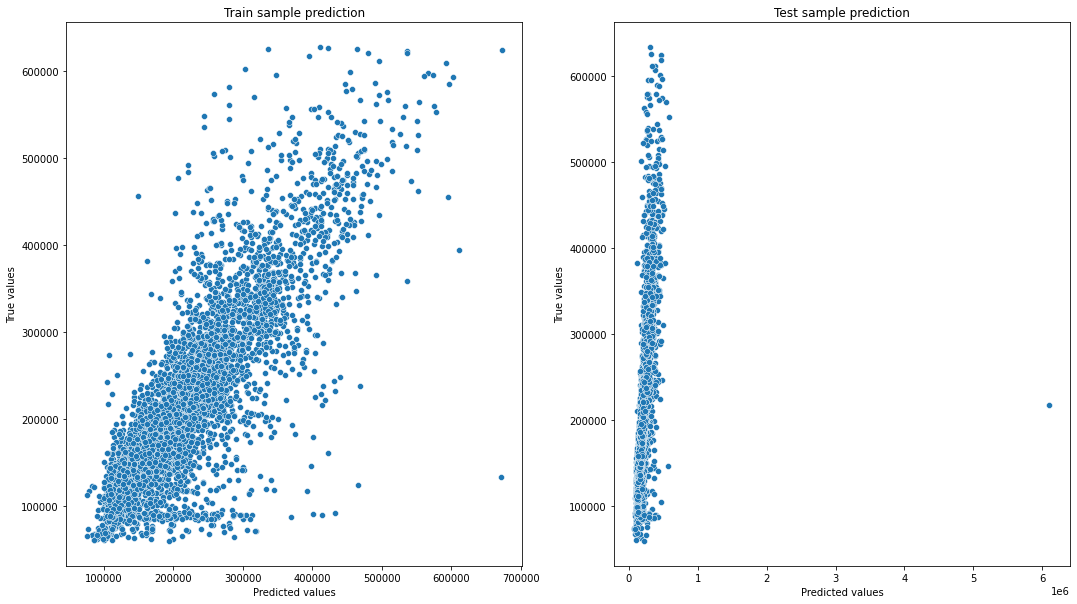

In [529]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
             
y_train_preds = lr_model.predict(X_train)
y_test_preds = lr_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)


Очень плохой результат. 
Train R2:	0.699 
Test R2:	-0.609

RandomForestRegressor

Train R2:	0.889
Test R2:	0.67


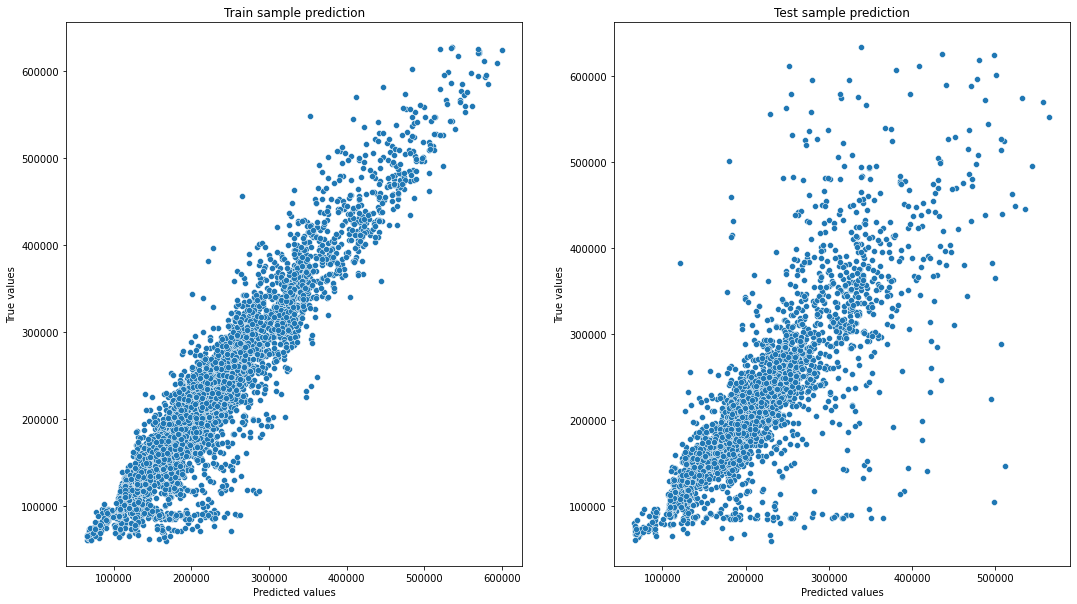

In [530]:
rf_model = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Гораздо лучше вариант. 
Train R2:	0.889
Test R2:	0.67

CatBoost

Train R2:	0.947
Test R2:	0.713


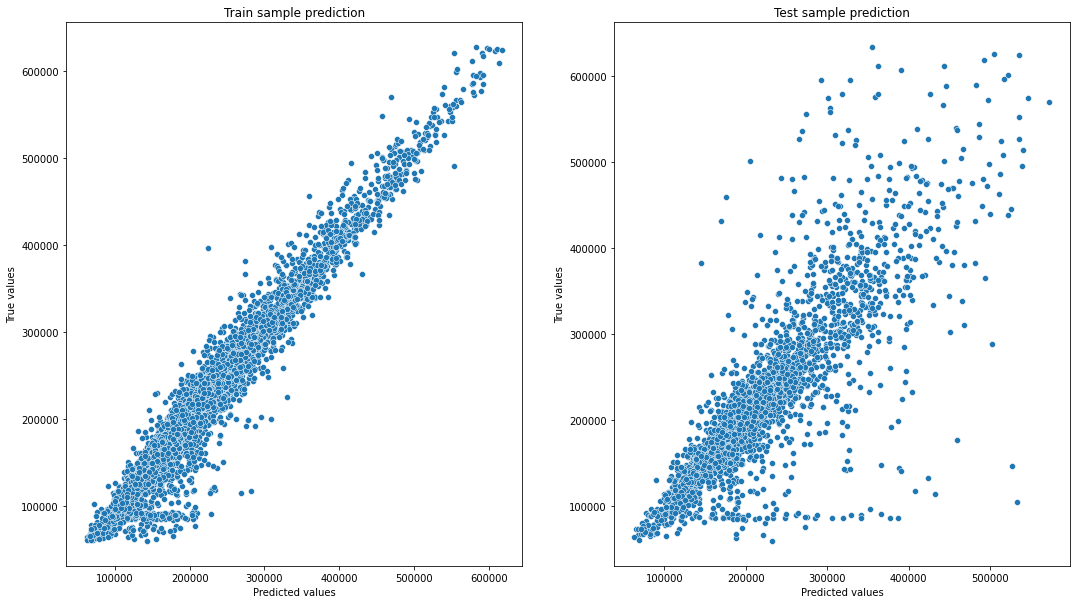

In [535]:
cb_model = CatBoostRegressor(learning_rate=0.02, depth=8, l2_leaf_reg=3, iterations=2500, loss_function='RMSE', eval_metric='R2', 
                             random_seed=21,silent=True)
cb_model.fit(X_train, y_train)

y_train_preds = cb_model.predict(X_train)
y_test_preds = cb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

CatBoost модель оказалась оптимальной с данными параметрами. При дальнейшем улучшении параметров очень долго проходит обучение, при этом на тренировочном датасете очень высокая точность предсказания, а на тестовом практически не изменяется.
Train R2:	0.947
Test R2:	0.713 

In [536]:
cv_score = cross_val_score(cb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.78065763, 0.74847837, 0.76453663])

In [537]:
cv_score.mean()

0.7645575459946702

In [539]:
feature_importances = pd.DataFrame(zip(X_train.columns, cb_model.feature_importances_), columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False).head(10)

,feature_name,importance
22,MedPriceByDistrict,27.497477
1,Square,13.711005
20,DistrictSize,5.623169
6,HouseYear,5.535185
23,MedPriceByFloorYear,5.412572
2,LifeSquare,5.105967
3,KitchenSquare,4.400317
5,HouseFloor,4.257067
7,Ecology_1,4.140898
12,Social_3,4.059302


# Прогнозирование на тестовом датасете

In [540]:
test_df.shape

(5000, 25)

In [541]:
test_df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,MedPriceByFloorYear,MedPriceByFloorRooms
0,1.0,36.847630,19.094182,5.0,5.0,9.0,1970,0.036122,1,1,...,1,0,0,0,0,76.0,0,171145.169069,186265.707329,156425.622693
1,1.0,55.568133,42.568133,10.0,7.0,17.0,2017,0.072158,1,1,...,0,0,0,0,0,164.0,1,131107.271962,179449.269388,157499.188345
2,2.0,59.463678,47.463678,9.0,19.0,19.0,1977,0.211401,1,1,...,1,0,0,0,1,580.0,1,165993.292450,175622.388268,215375.206027
3,3.0,49.646030,33.893825,6.0,2.0,2.0,1965,0.014073,1,1,...,1,0,0,0,0,372.0,1,172778.615365,179619.562520,248325.035023
4,1.0,53.837056,46.837056,4.0,8.0,17.0,1977,0.309479,1,1,...,1,0,0,0,1,65.0,0,164116.183543,192086.822606,154541.719537


In [542]:
#submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [545]:
predictions = cb_model.predict(test_df)
predictions

array([160793.43715118, 122725.7103082 , 141166.77308405, ...,
       147634.52619083, 194705.77341928, 253980.34953073])

In [546]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,160793.437151
1,5925,122725.710308
2,960,141166.773084
3,3848,139086.891467
4,746,181935.818813


In [547]:
submit.to_csv('rf_submit.csv', index=False)

In [548]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.tasks.common_metric import mean_quantile_error, rmsle

In [549]:
TARGET_NAME = target_name

In [550]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

preprocessor = DataPreprocessing()
preprocessor.fit(train_df)

X_train = preprocessor.transform(train_df)
X_test = preprocessor.transform(test_df)

features_gen = FeatureGenetator()
features_gen.fit(X_train, X_train[TARGET_NAME])

X_train = features_gen.transform(X_train)
test_df = features_gen.transform(test_df)

In [551]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorRooms,MedPriceByFloorYear
0,4567,44,1.0,36.847630,19.094182,5.0,5.0,9.0,1970,0.036122,...,0,0,0,104.0,1,1.0,2.0,171145.169069,155974.300833,186447.337908
1,5925,62,1.0,55.568133,42.568133,10.0,7.0,17.0,2017,0.072158,...,0,0,0,247.0,1,2.0,5.0,129107.218932,156067.264282,172932.855768
2,960,27,2.0,59.463678,47.463678,9.0,19.0,19.0,1977,0.211401,...,0,0,1,851.0,1,4.0,2.0,165683.084779,200552.798556,175503.767602
3,3848,23,3.0,49.646030,33.893825,6.0,2.0,2.0,1965,0.014073,...,0,0,0,565.0,1,0.0,2.0,166687.735824,244124.424428,179646.198587
4,746,74,1.0,53.837056,46.837056,4.0,8.0,17.0,1977,0.309479,...,0,0,1,114.0,1,2.0,2.0,165071.825722,159350.917190,192213.977261


In [552]:
TASK = Task('reg', loss='mse', metric=rmsle, greater_is_better=False)
TIMEOUT = 300000
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE =42
TARGET_NAME = 'Price'
TEST_SIZE = 0.2

In [553]:
roles = {'target': TARGET_NAME, 'drop': ['Id']}

In [554]:
automl_model = TabularAutoML(task=TASK,
                             timeout=TIMEOUT,
                             cpu_limit=N_THREADS,
                             gpu_ids='all',
                             reader_params= {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state':RANDOM_STATE},
                             general_params={'use_algos': [ ['lgb_tuned', 'cb_tuned', 'cb'], ['lgb_tuned', 'cb'] ]},
                             tuning_params={'max_tuning_iter': 10},
                             )

In [555]:
oof_pred = automl_model.fit_predict(X_train, roles = roles)

In [556]:
test_df['Price'] = automl_model.predict(test_df).data

In [557]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorRooms,MedPriceByFloorYear,Price
0,4567,44,1.0,36.847630,19.094182,5.0,5.0,9.0,1970,0.036122,...,0,0,104.0,1,1.0,2.0,171145.169069,155974.300833,186447.337908,161791.375000
1,5925,62,1.0,55.568133,42.568133,10.0,7.0,17.0,2017,0.072158,...,0,0,247.0,1,2.0,5.0,129107.218932,156067.264282,172932.855768,124087.578125
2,960,27,2.0,59.463678,47.463678,9.0,19.0,19.0,1977,0.211401,...,0,1,851.0,1,4.0,2.0,165683.084779,200552.798556,175503.767602,134881.890625
3,3848,23,3.0,49.646030,33.893825,6.0,2.0,2.0,1965,0.014073,...,0,0,565.0,1,0.0,2.0,166687.735824,244124.424428,179646.198587,133590.437500
4,746,74,1.0,53.837056,46.837056,4.0,8.0,17.0,1977,0.309479,...,0,1,114.0,1,2.0,2.0,165071.825722,159350.917190,192213.977261,168870.468750


In [558]:
test_df.to_csv('submission_LAMA.csv', columns=['Id', 'Price'], index=False)